In [1]:
using Revise

In [2]:
using
    UnitsToValue,
    Printf,
    Plots,
    ImageFiltering
;

include("YO_package.jl")
include("helper_functions.jl")
include("analyze_results.jl")
include("load_save_results.jl")
;

## Define Hamiltonian and molecular states

In [3]:
package = get_YO_package() # loads molecular structure (the states, their energy, Zeeman Hamiltonian, etc)
package_A = get_YO_package_12_A_states() # this includes more A states, for calculating AC Stark shift in the ODT.
k = package.k
Γ = package.Γ
m = package.m
λ = 2π / k

# add a 4.8 MHz hyperfine splitting in the A state
# package.states[14].E += 4.8e6
# package.states[15].E += 4.8e6
# package.states[16].E += 4.8e6
;

## Define experimental parameters

In [11]:
7s

14.906682486720705

In [45]:
## Initial condition of the molecule cloud
temp = @with_unit 100 "μK"
diameter = @with_unit 100 "μm"
displacement = [0.0, 0.0, 0.0]*1e-3
kick = [0,0, 0.0, 0.0]

## Define B field gradient and ramp time
# B_gradient = +50.0
# ramp_time = 2e-3

B_gradient = -4.0
ramp_time = 1e-6

## Laser intensities
Isat = π*h*c*Γ/(3λ^3) / 10 # 2.72 mW/cm^2

I = 5.8 # mW/cm^2, for each beam
s = I / Isat

# Laser detunings
detuning = 0.44 * 4.8 # Δ = 0.44Γ
δ1 = -0.264
δ2 = +0.0
δ3 = +0.0
δ4 = +0.0
δ5 = +0.0

Δ1 = 1e6 * (detuning + δ1) # addresses F=2
Δ2 = 1e6 * (detuning + δ2) # addresses F=1-
Δ3 = 1e6 * (detuning + δ3) # addresses F=1-
Δ4 = 1e6 * (detuning + δ4) # addresses F=1+ (~1 GHz higher)
Δ5 = 1e6 * (detuning + δ5) # addresses F=1+ (~1 GHz higher)

s1 = 1.0
s2 = 0.0s
s3 = 0.0s
s4 = 0.0s
s5 = 1.0

# ## Laser detunings - optimal so far
# detuning = 1.0 * 4.8 # Δ = 0.44Γ
# δ1 = +0.0
# δ2 = +0.0
# δ3 = +0.0
# δ4 = +0.6
# δ5 = -0.6

# Δ1 = 1e6 * (detuning + δ1) # addresses F=2
# Δ2 = 1e6 * (detuning + δ2) # addresses F=1-
# Δ3 = 1e6 * (detuning + δ3) # addresses F=1-
# Δ4 = 1e6 * (detuning + δ4) # addresses F=1+ (~1 GHz higher)
# Δ5 = 1e6 * (detuning + δ5) # addresses F=1+ (~1 GHz higher)

# s1 = 2.0s
# s2 = 0.0s
# s3 = 0.0s
# s4 = 2.0s
# s5 = 2.0s

# ## Laser detunings, 2 frequencies on F=2
# detuning = 1.0 * 5.0 #4.8 # Δ = 0.44Γ # make higher?
# δ1 = +0.6 # IIIb, -
# δ2 = -0.6 # (detuned to address F=2) # IIIa, +
# δ3 = +3.0 # II, +
# δ4 = +0.0
# δ5 = +0.0 # I, +

# Δ1 = 1e6 * (detuning + δ1) # addresses F=2
# Δ2 = 1e6 * (detuning + δ2) + 1e6 * 3.5 # addresses F=1- (but moved to F=2)
# Δ3 = 1e6 * (detuning + δ3) - 1e6 * 18.8 # addresses F=1- (but moved to F=0)
# Δ4 = 1e6 * (detuning + δ4) # addresses F=1+ (~1 GHz higher)
# Δ5 = 1e6 * (detuning + δ5) # addresses F=1+ (~1 GHz higher)

# s1 = 2.0s # 1 or 2?
# s2 = 2.0s
# s3 = 1.0s # need?
# s4 = 0.0s
# s5 = 2.0s

blue_MOT_params = MutableNamedTuple(t_start = 0.0, t_end = 5e-3, n_values = 40,
                                pol1_x=σ⁻, pol2_x=σ⁺, pol3_x=σ⁺, pol4_x=σ⁻, pol5_x=σ⁺,
                                s1=s1, s2=s2, s3=s3, s4=s4, s5=s5,
                                Δ1=Δ1, Δ2=Δ2, Δ3=Δ3, Δ4=Δ4, Δ5=Δ5,

                                B_gradient = B_gradient,
                                B_ramp_time = ramp_time,
                                Bz_offset = 0.0, By_offset = 0.0, Bx_offset=0.0,

                                temp=temp, diameter=diameter,
                                displacement=displacement, kick=kick,
                                s_ramp_time = ramp_time,
                                s_ramp_to_factor = 1.0,

                                photon_budget=Inf, dark_lifetime=1/(0.7e6)*Γ, FC_mainline=1,

                                pol_imbalance=0.0, 
                                s_imbalance = (0., 0., -0.), retro_loss=0., 
                                off_center=[0, -0, -0, 0, 0, 0].*1e-3, 
                                pointing_error =[0.0, 0.0, 0.0,0.0,0,0],

                                ODT_intensity = 0*13.3*1e3/(50e-4)^2,
                                ODT_size = (30e-6, 2e-3, 30e-6), 
                                ODT_revolutions = 3,
                                ODT_rmax = 100e-6, # distance of radial motion
                                ODT_tmax = 30e-3, # timescale of radial motion
                                ODT_motion_t_start = 30e-3,
                                ODT_motion_t_stop = 50e-3,

                                dt = 1e-2/4,

                                diffusion_constant = 0.0
)
;

## Find the diffusion constant

In [5]:
# results1 = deepcopy(results)
# results2 = deepcopy(results)
;

In [367]:
results_list = []

push!(results_list, results1)
push!(results_list, results2)

results = merge_results(results_list)
;

In [46]:
# results, diffusion_constant = find_diffusion_constant(blue_MOT_params, run_time=5e-3, n_particles=20,
#                                             ramp_time=1e-6, temp=100e-6, diameter=200e-6)
# @printf("Diffusion constant = %.2f \n", diffusion_constant)

blue_MOT_params.diffusion_constant = 0.008; #diffusion_constant
;

In [336]:
blue_MOT_params.diffusion_constant = diffusion_constant

0.08202158331463927

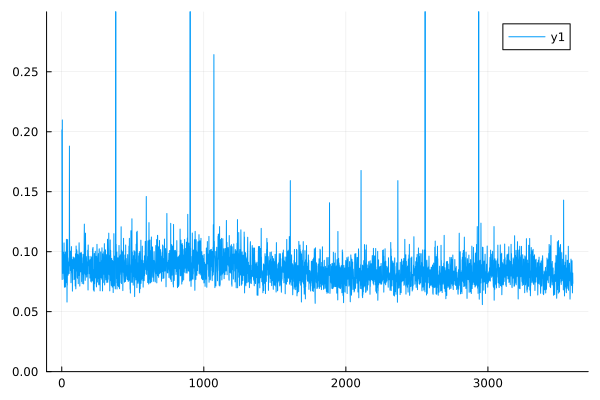

In [338]:
rec = [results.diffusion_records[i] for i ∈ survived_t(results,2,rmax=0.5)]
min_len = minimum(length.(rec))
plot()
xs = zeros(min_len)
for i in 1:min_len
    xs[i] = mean(x[i] for x in rec)
end
plot(xs)
plot!(ylim=[0,0.3])

## Run a constant-diffusion simulation
Define an experimental sequence. In this example, it's just the blue MOT. But we could also simulate an entire experimental sequence, such as 
red MOT -> lambda cooling -> blue MOT -> single frequency cooling -> ODT loading

In [47]:
sequence = [blue_MOT_params]
durations = [15e-3]
generate_sequence!(sequence, durations)

@time results = simulate_particles_constant_diffusion(package, package_A, sequence)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:24:29


1469.743581 seconds (123.79 k allocations: 31.818 MiB)


## Plot simulation results

### Plot the molecules' trajectories

Note that molecules that are too far away from the centre are discarded, which is why some trajectories end prematurely.

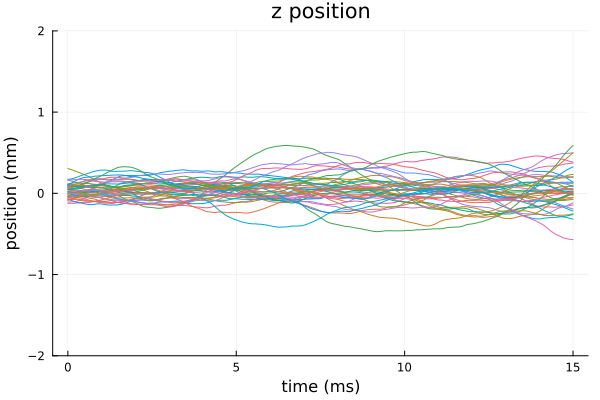

In [48]:
plot_all_trajectories(results, "z")
plot!(ylim=[-2,2])

### Plot the cloud size over time 
The size here is obtained from the standard dzviation of the position distribution.
There is also an option to find the final cloud size by fitting to a Gaussian.

Final size = 0.243 mm

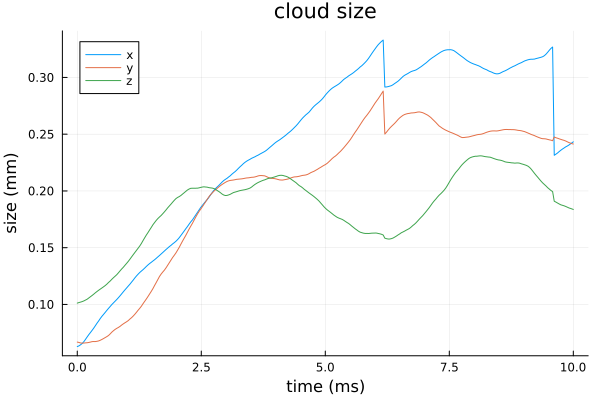

In [29]:
~, σ = plot_size(results, "all")
@printf("Final size = %.3f mm", σ[end])
plot!()

In [30]:
function survived(i, t_end, times)
    return t_end ≈ times[i][end]
end

times = results.times .* 1e-3
t_end = blue_MOT_params.t_end

survived_molecules = [i for i ∈ 1:results.n_values if survived(i, t_end, times)]

survived_times = times[survived_molecules]

survived_x_trajectories = results.x_trajectories[survived_molecules]
survived_y_trajectories = results.y_trajectories[survived_molecules]
survived_z_trajectories = results.z_trajectories[survived_molecules]
survived_x_velocities = results.x_velocities[survived_molecules]
survived_y_velocities = results.y_velocities[survived_molecules]
survived_z_velocities = results.z_velocities[survived_molecules]
;

In [31]:
function cloud_size(time, times, x_trajectories, y_trajectories, z_trajectories)
    xs = []
    ys = []
    zs = []
    for i ∈ eachindex(times)
        time_idx = searchsortedfirst(times[i], time)
        if length(times[i]) > time_idx
            push!(xs, x_trajectories[i][time_idx])
            push!(ys, y_trajectories[i][time_idx])
            push!(zs, z_trajectories[i][time_idx])
        end
    end
    return (std(xs) * std(ys) * std(zs))^(1/3)
end

using LsqFit

function Gaussian(x, p)
    σ, x0, A = p
   return A * exp.(-(x.-x0).^2/(2*σ^2))
end

function cloud_size_fitted(xs)

    hist_data = fit(Histogram, xs, -0.4:0.05:0.4)
    hist_data.isdensity = true
    v = collect(hist_data.edges[1])
    dv = v[2]-v[1]
    v = v[1:end-1] .+ dv/2
    fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

    histogram(hist_data)
    
    v_fit = curve_fit(Gaussian, v, fv, [0.5, 0., 5])
    σ, x0, A = v_fit.param
    
    histogram!(xs, bins=hist_data.edges, xlim=(-0.3, 0.3), alpha=0.5, normalize=true)
    
    return σ
end
;

In [32]:
using StatsBase

3-element Vector{Float64}:
  0.11348340826901306
 -0.040173966223834574
  3.3503417232901302

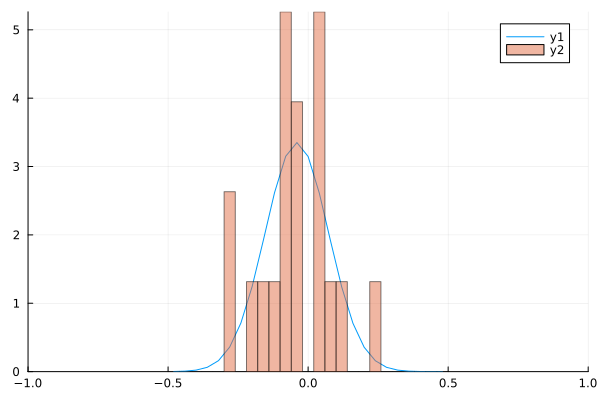

In [33]:
xs = [survived_x_trajectories[i][end] for i ∈ 1:length(survived_molecules)]
ys = [survived_y_trajectories[i][end] for i ∈ 1:length(survived_molecules)]
zs = [survived_z_trajectories[i][end] for i ∈ 1:length(survived_molecules)]

hist_data = fit(Histogram, zs, -0.5:0.04:0.5)
hist_data.isdensity = true
v = collect(hist_data.edges[1])
dv = v[2]-v[1]
v = v[1:end-1] .+ dv/2
fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

v_fit = curve_fit(Gaussian, v, fv, [0.05, 0., 5])
σ, x0, A = v_fit.param

display(v_fit.param)
plot(v, Gaussian(v, v_fit.param))
histogram!(zs, bins=hist_data.edges, xlim=(-1.0, 1.0), alpha=0.5, normalize=true)

In [34]:
cloud_sizes_x_fitted = [cloud_size_fitted([traj[i] for traj ∈ survived_x_trajectories]) for i ∈ eachindex(survived_x_trajectories[1])]
cloud_sizes_y_fitted = [cloud_size_fitted([traj[i] for traj ∈ survived_y_trajectories]) for i ∈ eachindex(survived_x_trajectories[1])]
cloud_sizes_z_fitted = [cloud_size_fitted([traj[i] for traj ∈ survived_z_trajectories]) for i ∈ eachindex(survived_x_trajectories[1])]
cloud_sizes_fitted = (abs.(cloud_sizes_x_fitted) .* abs.(cloud_sizes_y_fitted) .* abs.(cloud_sizes_z_fitted)).^(1/3)
;

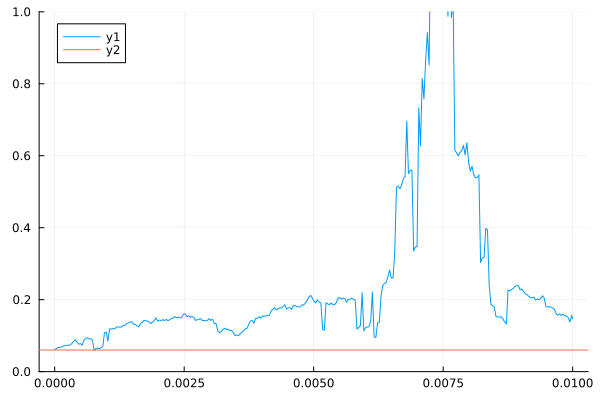

In [35]:
plot(survived_times[1], cloud_sizes_fitted, ylim=(0,1.0))
hline!([0.06])

### Plot temperature over time 
Temperatures here are obtained from the standard deviation of the velocity distribution. One could also fit the velocity distribution to a Gaussian.

Temperature = 147.6 uK

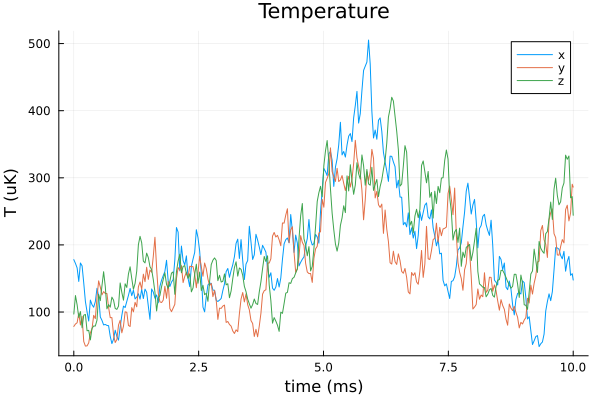

In [36]:
~, T = plot_temperature(results, "all")
@printf("Temperature = %.1f uK", T[end])
plot!()

### Plot the scattering rate of the molecules 
Scattering rate = excited state population * Γ

Average scattering rate = 0.18 MHz

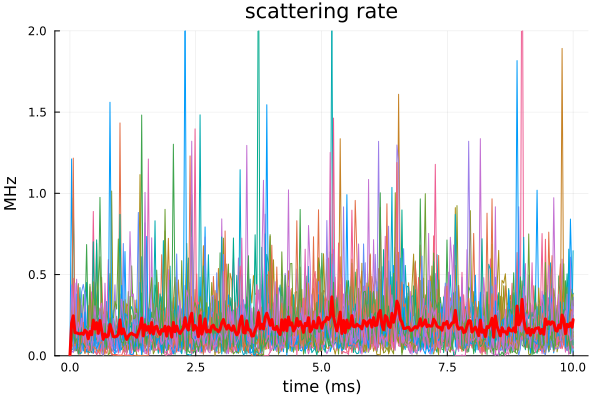

In [37]:
sr = plot_scattering_rate(results)
@printf("Average scattering rate = %.2f MHz", sr)
plot!(ylim=[0,2])

2-element Vector{Float64}:
 0.909136909691289
 0.00014580675294305307

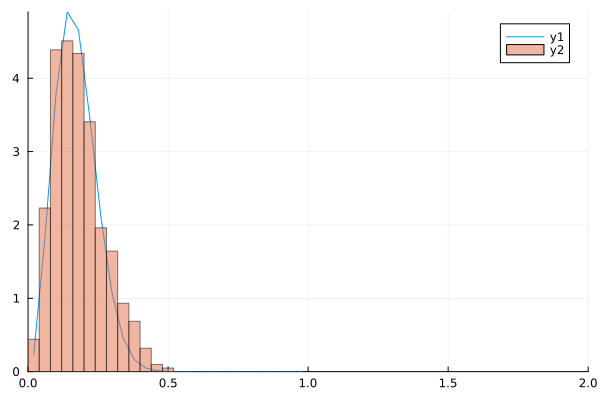

In [43]:
kB = 1.38e-23

survived_molecules = 1:20
velocities = [sqrt.(results.x_velocities[i].^2 .+ results.y_velocities[i].^2 .+ results.z_velocities[i].^2) for i ∈ survived_molecules];

function maxwell_boltzmann(v, p)
    A, T = p
    return A * ((m/(2π*kB*T))^(3/2) * 4π) .* v .^2 .* exp.(v .^2 .* (-m / (2*kB*T)))
end

# take velocities from t = 5 ms to t = 8 ms
vs = [[v[end-50:end] for v ∈ velocities]]
vs = vec(hcat(vs...))
vs = vec(hcat(vs...))
# vs = [[v[end-10] for v ∈ velocities]]
# vs = vec(hcat(vs...))

hist_data = StatsBase.fit(Histogram, vs, 0.0:0.04:1.0)
hist_data.isdensity = true
v = collect(hist_data.edges[1])
dv = v[2]-v[1]
v = v[1:end-1] .+ dv/2
fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

histogram(hist_data)

v_fit = curve_fit(maxwell_boltzmann, v, fv, [4, 100e-6])
A, T = v_fit.param

display(v_fit.param)
plot(v, maxwell_boltzmann(v, v_fit.param))
histogram!(vs, bins=hist_data.edges, xlim=(0.0, 2.0), alpha=0.5, normalize=true)

In [39]:
A = rand(1000000)
B = rand(1000000)
C = rand(1000000)

function add_AB_to_C!(C,A,B)
    for i ∈ eachindex(A,B)
        C[i] = A[i] + B[i]
    end
end

function add_AB_to_C_threaded!(C,A,B)
    Threads.@threads for i ∈ eachindex(A,B)
        C[i] = A[i] + B[i]
    end
end
;

In [379]:
using BenchmarkTools

In [74]:
@btime add_AB_to_C!($A,$B,$C)

  424.900 μs (0 allocations: 0 bytes)


In [75]:
@btime add_AB_to_C_threaded!($A,$B,$C)

  136.800 μs (58 allocations: 6.53 KiB)


In [ ]:
for step in steps
    for particle in particles

        # do whatever

    end
end